## PCB Images Training & Testing

### 1. Load the relevant libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
print(tf.__version__)

2.3.1


### 2. Load training set

In [2]:
training_set = tf.keras.preprocessing.image_dataset_from_directory(
    'D:/Docs/PCB/Training_Dataset',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    seed=123,
    image_size=(110, 42),
    shuffle=True,
    validation_split = 0.2,
    subset="training"
)

Found 12000 files belonging to 8 classes.
Using 9600 files for training.


### 3. Perform validity checks

In [3]:
class_names = training_set.class_names
print(class_names)
data_iterator = training_set.as_numpy_iterator()
batch = data_iterator.next()
print(batch[0].shape)
batch[1]

['0', '1', '2', '3', '4', '5', '6', '7']
(32, 110, 42, 3)


array([0, 0, 1, 0, 0, 0, 0, 3, 1, 1, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3,
       0, 4, 3, 0, 1, 0, 1, 0, 0, 4])

### 4. Plot some images

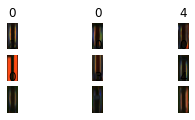

In [11]:
plt.figure(figsize=(110/25.4, 42/25.4))
for images, labels in training_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### 5. Standardize data

In [14]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = training_set.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99815303


In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_set = training_set.cache().prefetch(buffer_size=AUTOTUNE)

### 6. DEFINE the model

In [18]:
num_classes = 8

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [19]:
model.compile(
  optimizer = 'adam',
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics = ['accuracy'])

### 7. Validation Data

In [20]:
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    'D:/Docs/PCB/Training_Dataset',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    seed=123,
    image_size=(110, 42),
    shuffle=True,
    validation_split = 0.2,
    subset="validation"
)

Found 12000 files belonging to 8 classes.
Using 2400 files for validation.


### 8. Fit the model

In [25]:
history = model.fit(
  training_set,
  validation_data = validation_set,
  epochs=3
)

Epoch 1/3
300/300 [==============================] - 43s 144ms/step - loss: 0.0902 - accuracy: 0.9703 - val_loss: 0.1453 - val_accuracy: 0.9583
Epoch 2/3
300/300 [==============================] - 46s 152ms/step - loss: 0.0766 - accuracy: 0.9730 - val_loss: 0.1486 - val_accuracy: 0.9604
Epoch 3/3
300/300 [==============================] - 46s 152ms/step - loss: 0.0664 - accuracy: 0.9791 - val_loss: 0.1437 - val_accuracy: 0.9633


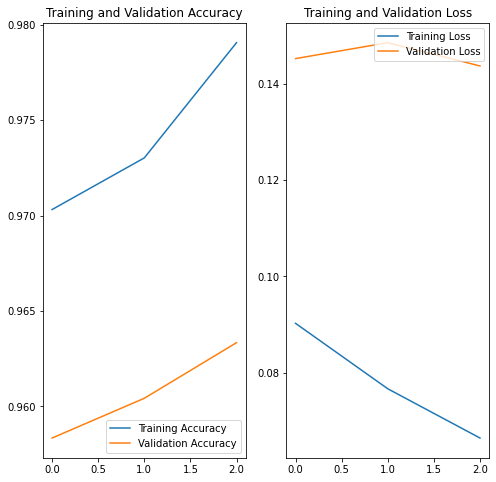

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(3)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 9. Predict from Evaluation Data

In [35]:
import cv2

In [123]:
test_path = "D:/Docs/PCB/Evaluation_Dataset"
x_test = []
for filename in os.listdir(test_path):
        img = cv2.imread(os.path.join(test_path, filename))
        h, w, c = img.shape
        img.shape = w, h, c
        x_test.append(img)

In [138]:
x_test = np.array(x_test)
#x_test = tf.expand_dims(x_test, axis=-1)
x_test = x_test.reshape(200, 110, 42, 3)
print(x_test.shape)
print(len(x_test))
new_test = x_test
print(len(new_test))

(200, 110, 42, 3)
200
200


In [139]:
# Output the class results to a text file
with open('class_output.txt', 'w') as f:
    f.write('Image Name                 Prob')
    f.write('\n')
    for val in range(len(new_test)):
        f.write(str(model.predict(new_test[val])))
        f.write('\n')

ValueError: in user code:

    C:\Users\SYED\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\SYED\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\SYED\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\SYED\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\SYED\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\SYED\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\SYED\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\SYED\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\SYED\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    C:\Users\SYED\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\functional.py:385 call
        return self._run_internal_graph(
    C:\Users\SYED\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\SYED\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\SYED\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\input_spec.py:191 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer conv2d is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: [None, 42, 3]
